From https://docs.pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html


In [ ]:
import math
import random
import pathlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.utils.tensorboard as tb
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
USE_ACCELERATOR = True
DATA_PATH = pathlib.Path("data")
TENSORBOARD_PATH = pathlib.Path("runs") / "fashion_mnist_lenet"
TORCH_SEED = 2147483647
SEED = 42

NUM_WORKERS_DATALOADER = 2
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1.0

# hyperparams
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
NUM_EPOCHS = 2


random.seed(SEED)
torch.manual_seed(TORCH_SEED)

writer = tb.SummaryWriter(TENSORBOARD_PATH)
device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available() and USE_ACCELERATOR
    else torch.device("cpu")
)
device

device(type='cuda')

In [3]:
# normalize for better training
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=DATA_PATH, train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS_DATALOADER
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS_DATALOADER
)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
 Coat T-shirt/top  Coat Trouser Dress Dress Shirt T-shirt/top Ankle boot Dress Trouser Ankle boot Shirt Sneaker  Coat Trouser Sneaker Ankle boot Pullover Trouser Dress Dress Shirt  Coat Trouser Sneaker Shirt Shirt   Bag Sneaker Sandal Shirt Ankle boot Pullover  Coat T-shirt/top T-shirt/top Sneaker Trouser Shirt Dress Trouser Pullover Pullover Pullover Sneaker Ankle boot Dress Sandal Pullover  Coat Shirt Sandal   Bag   Bag Shirt Sneaker  Coat Sandal Sandal Trouser Sandal Sneaker Ankle boot


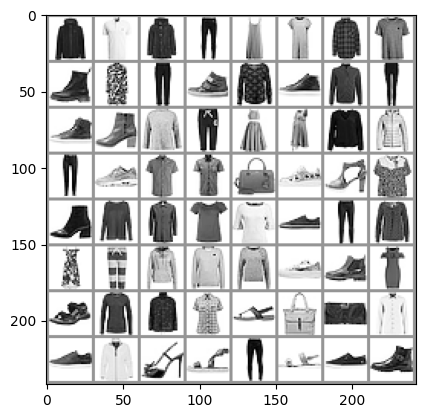

In [4]:
for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


def imshow(img: torch.Tensor, one_channel: bool = False) -> None:
    if one_channel:
        img = img.mean(dim=0)  # convert to grayscale
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, one_channel=True)
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(BATCH_SIZE)))
writer.add_image("Fashion-MNIST Images", img_grid)
writer.flush()

In [5]:
from typing import Callable


class Lambda(nn.Module):
    def __init__(self, func: Callable[[torch.Tensor], torch.Tensor]) -> None:
        super().__init__()
        self.func = func

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.func(x)


class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            Lambda(lambda x: x.view(-1, 1, 28, 28)),
            nn.Conv2d(1, 6, kernel_size=5),  # 6@24x24
            nn.ReLU(),
            # subsampling: max pooling over (2, 2) kernel
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5),  # 16@8x8
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)  # logits output
        return x


model = LeNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

LeNet(
  (model): Sequential(
    (0): Lambda()
    (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=256, out_features=120, bias=True)
    (9): ReLU()
    (10): Linear(in_features=120, out_features=84, bias=True)
    (11): ReLU()
    (12): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [6]:
def train(
    dataloader: data_utils.DataLoader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    writer: tb.SummaryWriter,
    epoch: int = 0,
) -> None:
    size = len(dataloader.dataset)
    model.train()  # set train mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # forward
        logits = model(X)
        loss = loss_fn(logits, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            writer.add_scalar("Training Loss", loss, epoch * size + current)
    writer.flush()


def test(
    dataloader: data_utils.DataLoader,
    model: nn.Module,
    loss_fn: nn.CrossEntropyLoss,
    writer: tb.SummaryWriter,
) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y).item()
            correct += (logits.argmax(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    writer.add_scalar("Test Accuracy", 100 * correct)
    writer.add_scalar("Test Loss", test_loss)
    writer.flush()


test(testloader, model, loss_fn, writer)

Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302065 



In [7]:
for t in range(NUM_EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer, writer, epoch=t)
    test(testloader, model, loss_fn, writer)

Epoch 1
-------------------------------
loss: 2.288028  [   64/60000]
loss: 2.289986  [ 6464/60000]
loss: 2.289946  [12864/60000]
loss: 2.283754  [19264/60000]
loss: 2.244750  [25664/60000]
loss: 2.123288  [32064/60000]
loss: 1.724800  [38464/60000]
loss: 1.278948  [44864/60000]
loss: 0.885917  [51264/60000]
loss: 0.997214  [57664/60000]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.848762 

Epoch 2
-------------------------------
loss: 0.878294  [   64/60000]
loss: 0.671891  [ 6464/60000]
loss: 0.747732  [12864/60000]
loss: 0.731476  [19264/60000]
loss: 0.701783  [25664/60000]
loss: 0.753534  [32064/60000]
loss: 0.790616  [38464/60000]
loss: 0.738321  [44864/60000]
loss: 0.828511  [51264/60000]
loss: 0.616177  [57664/60000]
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.692439 



In [9]:
# Again, grab a single mini-batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(model, images.to(device))
writer.flush()

In [10]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


# Extract a random subset of data
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.flush()
writer.close()